In [1]:
import re
import sys
sys.path.append("../../")
%cd ../../

/Users/I516998/Documents/uni - mannheim/ankinator/ankinator-flashcard-models


# Dataset Analysis of the current Data we collected

In [2]:
from ankipandas import Collection
import matplotlib.pyplot as plt
import regex as re
import pandas as pd

In [3]:
col = Collection()
print("We currently have ", len(col.cards.cdeck.unique()), "Decks in the Dataset, with a total of ", len(col.notes), "flashcards")
col.cards.cdeck.unique()

INFO: Searching for database. This might take some time. You can speed this up by specifying a search path or directly entering the path to your database.


We currently have  78 Decks in the Dataset, with a total of  1806 flashcards


array(['PLUs O&G A', 'PLUs O&G B', 'PLUs O&G C', 'PLUs O&G E-G',
       'PLUs O&G U-Z', 'PLUs O&G H-K', 'PLUs O&G L-P', 'PLUs O&G Q-T',
       'PLUs Backwaren A-D', 'PLUs Backwaren I-P', 'PLUs Backwaren Q-T',
       'PLUs Backwaren E-H', 'PLUs Backwaren U-Z', 'Formeln I&F',
       'FiBu Buchungssätze', 'Mikroökonomie',
       'Methoden empirischer Sozialforschung', 'Personal',
       'Standortanalyse', 'VWL Makro', 'Orga und PM', 'Default', 'DB II',
       'Sozialpsychologie', 'IT-Sicherheit', 'Arbeitsrecht',
       'Handelsrecht', 'Handelsgeschäfte', 'Gesellschaftsrecht',
       'Beendigung AV und Kündigung', 'Kundenzufriedenheit',
       'Preismanagement', 'Infosysteme', 'Komm. Pol.',
       'Key Account Management', 'Revision & Corporate Governance',
       'Vertriebsmanagement', 'LSDM', 'CS 500 ASE\x1f02_Testing',
       'MAN 645 L&M\x1f01_Introduction', 'Information Retrieval',
       'MAN 645 L&M\x1f02_Trait approach',
       'MAN 645 L&M\x1f03_Skills approach',
       'CS 500 AS

In [32]:
col.cards.cdeck[col.cards.cdeck.str.match(r"(CS 500|LSDM|MAN 645|IE 560|Data Security|Information Retrieval).*") == True].nunique()

36

36 of these Decks are in English, the others are German.

/var/folders/xm/s6jjw11s1vx4n32w6313vgy80000gn/T/ipykernel_45594/1711595266.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


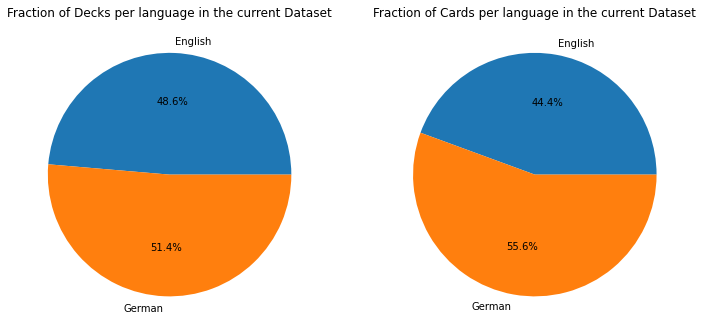

In [4]:
X_decks = [(36 / 74)*100, 100-((36 / 74)*100)]
labels = ["English", "German"]

n_english_cards = col.cards.cdeck[col.cards.cdeck.str.match(r"(CS 500|LSDM|MAN 645|IE 560|Data Security|Information Retrieval|Advanced SE).*") == True].count()
X_cards = [(n_english_cards / len(col.notes)) * 100, 100 - ((n_english_cards / len(col.notes)) * 100)]

fig, ax = plt.subplots(ncols=2,figsize=(12,12))
ax[0].set_title("Fraction of Decks per language in the current Dataset")
ax[1].set_title("Fraction of Cards per language in the current Dataset")
ax[0].pie(X_decks, labels=labels, autopct='%1.1f%%')
ax[1].pie(X_cards, labels=labels, autopct='%1.1f%%')
fig.show()

In [6]:
col.notes.help_col(column="nflds")

Help for column 'nflds'
-----------------------
Name in raw Anki database: flds
Information from table: notes
Present by default: True

Description: Fields of the card as list. In the raw anki database the fields are encoded as a string joined by ‘\x1f’ characters.


In [16]:
col.notes

,nguid,nmod,nusn,ntags,nflds,nmodel
nid,,,,,,
1602000315721,OC}<1,1602000342,-1,[],"[Ananas, 620]",Standard
1602000342440,@e6AP,1602000365,-1,[],"[Apfel grün, lose, 11]",Standard
1602000391625,{]}%I,1602000443,-1,[],"[Apfel rot, süß-säuerlich lose, 58]",Standard
1602000443718,Q%8GO,1602000460,-1,[],"[Aprikosen, lose, 40]",Standard
1602000460567,Dkmc,1602000479,-1,[],"[Avocado, Stück, 621]",Standard
...,...,...,...,...,...,...
1677937216242,C4J?7,1677938427,-1,[],[Nennen sie die 2 Strategien der Beurteilung v...,Standard
1677938427446,w!Jw8,1677939124,-1,[],"[Berufskrankheit, Liegt vor, wenn eine versich...",Standard
1677939124208,U:G#5,1677939220,-1,[],"[Aufgaben der Berufsgenossenschsften, Präventi...",Standard


The content of the card is included in the nflds column. Which includes a list of strings. The First string is the front of the Flashcard which equates to the Question we'd want to generate. However, we should also look through the Data and delete unnecessary decks as one deck is completely composed of IDs for the Cash register at the supermarket for fruits, that type of data will create unnecessary noise and is not beneficial for our goal. In addition to that, the Text includes HTML tags like \<br\> or \<image\> tags that should also be removed for some models to reduce noise. We also have to remove all cards that only include images as the solution, as the llms won't have any way to extract the content of the image and in theory would learn to generate some form of text ot a random img number string.

In [5]:
col.notes.nflds.apply(lambda x: bool(re.match(r".*[?]" ,x[0]))).value_counts()

False    1257
True      549
Name: nflds, dtype: int64

In [6]:
(col.notes.nflds.apply(lambda x: bool(re.match(r".*[?]" ,x[0]))).value_counts() / len(col.notes))*100

False    69.601329
True     30.398671
Name: nflds, dtype: float64

Also as shown above, with some very simple and trivial grammatical classification for Questions, only 30.4% of cards actually have a Question at the Front of the card. The rest is composed of either Key Words or actual exercise assignments where the user wanted to learn a specific equation that is used for calculating the answer. Thus overall the dataset resembles more like a key message / Topic summary task / Topic prediction task, comparable to school exercises where a part of a story or scientific text had to be summarised in a paragraph title.

## Textual Data
The textual Data is comprised of many different forms of Data. We have:
- Bullet points
- Images, through image tags with a source reference
- Formulas
- Structured Tags from HTML, e.g. \<br> for Line breaks
- Data can contain Typos
- Data can include scientific errors / incorrect answers -> shouldn't be a concern as we only predict the topic / the overall key message

Not everything of that can be efficiently processed by one model, e.g. Images can't be processed by an NLP model as it basically defines a completely different task. Structured Content in theory is no problem but it can be noisy for a model to include it depending on a models pretraining -> See IR Project. Also the result from the Extractor won't be structured. It will include "bullet points" in markdown notation through utf-8 characters but no line breaks through html tags or similar stuff. Formulas are not written in Latex in Anki, they are just written in plain text (show example in the report).

## Check how many image pastes we have

In [7]:
col.notes.nflds.apply(lambda x: bool(re.match(r"<img.*" ,x[1]))).value_counts()

False    1435
True      371
Name: nflds, dtype: int64

In [8]:
(col.notes.nflds.apply(lambda x: bool(re.match(r"<img.*" ,x[1]))).value_counts() / len(col.notes))*100

False    79.457364
True     20.542636
Name: nflds, dtype: float64

-> We have around 21% of image data in the result field

In [9]:
(col.notes.nflds.apply(lambda x: bool(re.match(r"<img.*" ,x[0]))).value_counts() / len(col.notes))*100

False    99.390919
True      0.609081
Name: nflds, dtype: float64

-> Less then 1% of Questions are composed of Images

## Topic Distributions

In [10]:
pd.Series(col.cards.cdeck.unique()).sort_values().to_csv("datasets/deck_names.csv",encoding='utf-8')

In [11]:
tagged = pd.read_csv("datasets/deck_names_tagged.csv", encoding='utf-8', delimiter=';', index_col='ID').drop(['Unnamed: 3'], axis=1)
tagged

,Deck_Name,Topic
ID,,
52,Advanced SE,Computer Science
22,Arbeitsrecht,Business Economics / Management
72,Arbeitssicherheit,Business Economics / Management
26,Beendigung AV und Kündigung,Business Economics / Management
35,CS 500 ASE 02_Testing,Computer Science
...,...,...
17,VWL Makro,Business Economics / Management
33,Vertriebsmanagement,Business Economics / Management
77,Mikroökonomie,Social Sciences


In [12]:
cards_cdecks = col.cards
cards_cdecks

,nid,cord,cmod,cusn,ctype,cqueue,cdue,civl,cfactor,creps,clapses,cleft,codue,cdeck,codeck
cid,,,,,,,,,,,,,,,
1602000342408,1602000315721,0,1678209718,-1,learning,new,559,0,2500,0,0,1001,0,PLUs O&G A,
1602000365845,1602000342440,0,1678209718,-1,learning,new,560,0,2500,0,0,1001,0,PLUs O&G A,
1602000443666,1602000391625,0,1678209718,-1,learning,new,561,0,2500,0,0,1001,0,PLUs O&G A,
1602000460521,1602000443718,0,1678209718,-1,learning,new,562,0,2500,0,0,1001,0,PLUs O&G A,
1602000479703,1602000460567,0,1678209718,-1,learning,new,563,0,2500,0,0,1001,0,PLUs O&G A,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677938427431,1677937216242,0,1678209718,-1,learning,new,1035,0,2500,0,0,1001,0,Arbeitssicherheit,
1677939124198,1677938427446,0,1678209718,-1,learning,new,1036,0,2500,0,0,1001,0,Arbeitssicherheit,
1677939220981,1677939124208,0,1678209718,-1,learning,new,1037,0,2500,0,0,1001,0,Arbeitssicherheit,


In [13]:
cards_cdecks_tagged = pd.merge(cards_cdecks, tagged, left_on='cdeck', right_on='Deck_Name')
cards_cdecks_tagged

,nid,cord,cmod,cusn,ctype,cqueue,cdue,civl,cfactor,creps,clapses,cleft,codue,cdeck,codeck,Deck_Name,Topic
0,1602000315721,0,1678209718,-1,learning,new,559,0,2500,0,0,1001,0,PLUs O&G A,,PLUs O&G A,Noise
1,1602000342440,0,1678209718,-1,learning,new,560,0,2500,0,0,1001,0,PLUs O&G A,,PLUs O&G A,Noise
2,1602000391625,0,1678209718,-1,learning,new,561,0,2500,0,0,1001,0,PLUs O&G A,,PLUs O&G A,Noise
3,1602000443718,0,1678209718,-1,learning,new,562,0,2500,0,0,1001,0,PLUs O&G A,,PLUs O&G A,Noise
4,1602000460567,0,1678209718,-1,learning,new,563,0,2500,0,0,1001,0,PLUs O&G A,,PLUs O&G A,Noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,1677865211394,0,1678209718,-1,learning,new,1027,0,2500,0,0,1001,0,Einkauf,,Einkauf,Business Economics / Management
1802,1677865806998,0,1677870513,-1,learning,new,555,0,0,0,0,0,0,Einkauf,,Einkauf,Business Economics / Management
1803,1677870513808,0,1677872175,-1,learning,new,556,0,0,0,0,0,0,Einkauf,,Einkauf,Business Economics / Management
1804,1677872175641,0,1677873066,-1,learning,new,557,0,0,0,0,0,0,Einkauf,,Einkauf,Business Economics / Management


In [14]:
topic_counts = cards_cdecks_tagged.groupby('Topic').count()
topic_counts

,nid,cord,cmod,cusn,ctype,cqueue,cdue,civl,cfactor,creps,clapses,cleft,codue,cdeck,codeck,Deck_Name
Topic,,,,,,,,,,,,,,,,
Business Economics / Management,541,541,541,541,541,541,541,541,541,541,541,541,541,541,541,541
Noise,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148
Computer Science,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051
Social Sciences,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66


<AxesSubplot:title={'center':'Topic distribution in the Collected Data'}, ylabel='nid'>

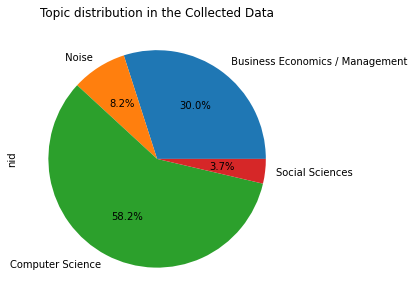

In [15]:
topic_counts.plot.pie(y='nid', figsize=(5,5), legend=False, autopct='%1.1f%%', title="Topic distribution in the Collected Data")

## Model Goal
<div>
<img src="./images/Model-Goal.png" width="1500"/>
</div>